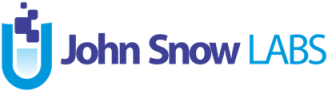

# 🚀 JohnSnowLabs Medical LLM Inference Server

### 🔄 The images required to run the llm have been pulled from 
 👉 [Docker Hub](https://hub.docker.com/r/johnsnowlabs/jsl-llms):


### 🐳 The containers are running at system startup


Check running the containers with:

```bash
docker ps
```
It should show 2 containers running, johnsnowlabs/jsl-llms:marketplace runs the model. 
ghcr.io/open-webui/open-webui:main runs webui to interact with the model.

```
CONTAINER ID   IMAGE                                COMMAND                  CREATED      STATUS                            PORTS                                         NAMES
4dbe81768b8b   johnsnowlabs/jsl-llms:marketplace    "./entrypoint.sh --m…"   2 days ago   Up 2 minutes (health: starting)   0.0.0.0:8080->8080/tcp, [::]:8080->8080/tcp   med-llm-cmp-jsl-llms-1
684bf3801bf8   ghcr.io/open-webui/open-webui:main   "bash start.sh"          2 days ago   Up 2 minutes (healthy)            0.0.0.0:3000->8080/tcp, [::]:3000->8080/tcp   open-webui
```
---

### 📜 View Container Logs

You can monitor the container logs with:

```bash
docker logs <container-id>
```

The logs will show important information such as:
- Model initialization and loading progress
- License validation status
- Server startup confirmation
- Memory usage and GPU configuration
- Model task capabilities
- Available API endpoints and routes
- Health check status


Example log entry for successful startup of johnsnowlabs/jsl-llms:marketplace:
```bash
INFO: Application startup complete.
llm-service [INFO] Server is healthy and model is loaded
INFO: Started server process [1]
INFO:     127.0.0.1:42154 - "GET /health HTTP/1.1" 200 OK
```

Once you see these messages, the service is ready to accept requests! 🎉

## Imports

In [1]:
import json
import requests

## Initial setup

In [2]:
prompt1 = "How do emerging mRNA technologies compare to traditional vaccine approaches for disease prevention?"

prompt2 = """Patients with xeroderma pigmentosum develop skin cancer when they are exposed to sunlight because they have a deficiency in:

A. An enzyme essential to repair mismatched bases.
B. UV specific endonuclease.
C. DNA polymerase I.
D. DNA polymerase III.
E. Glycosylase that removes uracil bases from DNA."""

system_prompt = """You are a medical expert that reviews the problem, does reasoning, and then gives a final answer.
Strictly follow this exact format for giving your output:

<think>
reasoning steps
</think>

**Final Answer**: [Conclusive Answer]"""

# Health & Version:

In [3]:
url = "http://localhost:8080/health"
response = requests.get(url)
print("Health:", response.status_code, response.text)

Health: 200 


In [4]:
url = "http://localhost:8080/ping"
response = requests.post(url)
print("Ping:", response.status_code, response.text)

Ping: 200 


In [5]:
url = "http://localhost:8080/version"
response = requests.get(url)
print("Version:", response.json())

Version: {'version': '0.9.2'}


# Core Functionality:

### List available models

In [6]:
url = "http://localhost:8080/v1/models"
response = requests.get(url)
print("Models:", response.json())

Models: {'object': 'list', 'data': [{'id': 'Medical-Reasoning-LLM-32B', 'object': 'model', 'created': 1753267414, 'owned_by': 'vllm', 'root': 'Medical-Reasoning-LLM-32B', 'parent': None, 'max_model_len': 40960, 'permission': [{'id': 'modelperm-426e349694ca41c49f4e9bbdc8baf32f', 'object': 'model_permission', 'created': 1753267414, 'allow_create_engine': False, 'allow_sampling': True, 'allow_logprobs': True, 'allow_search_indices': False, 'allow_view': True, 'allow_fine_tuning': False, 'organization': '*', 'group': None, 'is_blocking': False}]}]}


## Non-Streaming Responses

In [17]:
def get_completion_response(url, payload):
    """
    Handles non-streaming responses from both `/v1/chat/completions` and `/v1/completions`.

    Args:
        url (str): The endpoint URL.
        payload (dict): The request payload.

    Returns:
        str: The generated text (chat or completion).
    """
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        data = response.json()
        
        choices = data.get("choices", [{}])

        res = dict()
        if "message" in choices[0]:
            res["content"] = choices[0]["message"].get("content", "")
            res["reasoning_content"] = choices[0]["message"].get("reasoning_content", "")
            return res

        return choices[0].get("text", "")
    else:
        print("Error:", response.status_code, response.text)
        return ""

### Chat completions

In [18]:
url = "http://localhost:8080/v1/chat/completions"
payload = {
    "model": "Medical-Reasoning-LLM-32B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.8,
    "top_p": 0.95,
}

response = get_completion_response(url, payload)
print(f"reasoning: {response['content']}")
print(f"response: {response['reasoning_content']}")

reasoning: 

**Final Answer**: Emerging mRNA technologies and traditional vaccine approaches each have distinct advantages and challenges. mRNA vaccines offer rapid development timelines, potential for strong and durable immune responses (including both humoral and cellular immunity), and flexibility for quick updates against new variants. However, they face challenges in storage (requiring ultra-cold temperatures) and long-term safety data. Traditional vaccines, such as live attenuated or inactivated pathogen-based approaches, have well-established safety records, simpler storage requirements, and often lower production costs for long-term use. They may, however, require longer development times and may not elicit as robust or adaptable immune responses. The choice between approaches depends on the disease, infrastructure, and urgency of response.
response: 
Okay, so I need to compare emerging mRNA technologies with traditional vaccine approaches for disease prevention. Let me start b

For additional parameters and details, refer to:

- [ChatCompletionRequest](https://github.com/vllm-project/vllm/blob/v0.8.5/vllm/entrypoints/openai/protocol.py#L232)
- [OpenAI’s Chat Completions API](https://platform.openai.com/docs/api-reference/chat/create)

### Text completions

In [26]:
url = "http://localhost:8080/v1/completions"
payload = {
    "model": "Medical-Reasoning-LLM-32B",
    "prompt": f"{system_prompt}\n\nUser: {prompt2}\n\nAssistant:",
    "max_tokens": 2048,
    "temperature": 0.8,
    "top_p": 0.95,
}

response = get_completion_response(url, payload)

print(f"response: {response}")

response: <think>
Okay, so I need to figure out which answer is correct for this question about xeroderma pigmentosus. The question is asking why patients with this condition develop skin cancer when exposed to sunlight, and the options are about various enzymes involved in DNA repair or replication.

Xeroderma pigmentosum (XP) is a genetic disorder that makes people extremely sensitive to ultraviolet (UV) light. From what I remember, this disease is related to a defect in the body's ability to repair DNA damage caused by UV radiation. UV light, especially from sunlight, can cause thymine dimers in the DNA, which can lead to mutations if not properly repaired. If the repair process is defective, the person is more susceptible to skin cancer.

The question is asking which enzyme is deficient in XP patients. The options are:

A. An enzyme essential to repair mismatched bases.
B. UV specific endonuclease.
C. DNA polymerase I.
D. DNA polymerase III.
E. Glycosylase that removes uracil bases

For further details and additional parameters, see:

- [CompletionRequest](https://github.com/vllm-project/vllm/blob/v0.8.5/vllm/entrypoints/openai/protocol.py#L730)
- [OpenAI’s Completions API](https://platform.openai.com/docs/api-reference/completions/create)

# Streaming Responses

In [29]:
def stream_response(url, payload):
    """
    Handles streaming responses from both `/v1/chat/completions` and `/v1/completions`.

    Args:
        url (str): The API endpoint URL.
        payload (dict): The JSON payload for the request.

    Prints the reconstructed streamed output in real-time.
    """
    response = requests.post(url, json=payload, stream=True)

    for chunk in response.iter_lines():
        if chunk:
            decoded = chunk.decode("utf-8")
            if decoded.startswith("data: "):
                data = decoded[len("data: "):]
                if data.strip() == "[DONE]":
                    break
                try:
                    parsed = json.loads(data)
                    choices = parsed.get("choices", [])
                    if not choices:
                        continue
                    choice = choices[0]

                    content = choice.get("delta", {}).get("content") or choice.get("text")
                    if content:
                        print(content, end="", flush=True)
                except (KeyError, json.JSONDecodeError):
                    continue


### Chat completions

In [30]:
url = "http://localhost:8080/v1/chat/completions"

payload = {
    "model": "Medical-Reasoning-LLM-32B",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.8,
    "top_p": 0.95,
    "stream": True
}

stream_response(url, payload)



**Final Answer**: Emerging mRNA technologies offer several advantages over traditional vaccine approaches, including rapid development and production, adaptability to new variants, and strong immune responses. However, they face challenges such as the need for cold storage and distribution, while traditional vaccines, though well-established and stable, require longer development times and are less flexible for variant-specific updates. The choice between the two depends on factors like disease urgency, infrastructure, and long-term safety data.

### Text completions

In [31]:
url = "http://localhost:8080/v1/completions"

payload = {
    "model": "Medical-Reasoning-LLM-32B",
    "prompt": f"{system_prompt}\n\nUser: {prompt2}\n\nAssistant:",
    "max_tokens": 2048,
    "temperature": 0.8,
    "top_p": 0.95,
    "stream": True
}

stream_response(url, payload)

<think>
Okay, so I need to figure out which deficiency in xeroderma pigmentosus (XP) leads to skin cancer from sun exposure. XP is a genetic disorder, right? The key here is understanding the DNA repair mechanisms involved.

The question is about what enzyme is deficient. The options are related to DNA repair. XP patients are extremely sensitive to UV light, and their skin cancer risk is high when exposed. I remember that XP is connected to defects in the nucleotide excision repair (NER) pathway. NER is the process that removes bulky DNA lesions, like those caused by UV light (like pyrimidine dimers).

So, the main enzymes involved in NER include the endonucleases that cut the DNA on both sides of the damaged site. The correct enzyme here is the UV-specific endonuclease. XP patients have mutations in genes that code for proteins involved in this repair process. The UV-specific endonuclease would be part of that. 

Looking at the options: A is about mismatch repair, which is for base pa


## Additional Endpoints  
You can access other API routes depending on the model's capabilities. Check your server startup logs for supported tasks and their corresponding endpoints.

The full list of available routes is logged during service initialization.